Note: read without environment activated, as the environment for pointer sort has no matplotlib

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [1]:
import seaborn as sns
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style({'font.family': ['computer modern roman']})
sns.set_context("paper")

In [2]:
def fbeta_score(precision, recall, beta=1):
    upper_part = precision * recall
    lower_part = (beta**2 * precision) + recall
    factor = (1.0 + beta**2)
    return factor * (upper_part / lower_part)


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [3]:
colors = {
    'accuracy': '#148F77',
    'recall': '#FF5733',
    'precision': '#FFC300',
    'fbeta': '#4167DF'
}
names = {
    'accuracy': r'$accuracy$',
    'recall': r'$recall$',
    'precision': r'$precision$',
    'fbeta': r'$F_{\beta}, \beta = 1$'
}
positions = {
    'accuracy': '0,0',
    'recall': '0,1',
    'precision': '1,0',
    'fbeta': '1,1'
}

# Net-specific analysis

In [4]:
version = 'np'
log_df = pd.read_csv('logging/schema_pointer_{}.txt'.format(version))
log_df.head()

,epoch,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision
0,1,0.405664,0.416801,0.411464,0.417389,0.408243,0.417389
1,2,0.410927,0.427656,0.416677,0.466504,0.419352,0.466504
2,3,0.440870,0.504523,0.475573,0.569486,0.535265,0.569486
3,4,0.517374,0.562806,0.568234,0.615182,0.645593,0.615182
4,5,0.535840,0.568764,0.590102,0.622536,0.673458,0.622536


In [5]:
log_df['train_fbeta'] = ''
log_df['test_fbeta'] = ''
for idx, row in log_df.iterrows():
    train_precision, train_recall = row[['train_precision', 'train_recall']]
    test_precision, test_recall = row[['test_precision', 'test_recall']]
    row['train_fbeta'] = fbeta_score(train_precision, train_recall)
    row['test_fbeta'] = fbeta_score(test_precision, test_recall)
    log_df.loc[idx] = row
log_df.head()

,epoch,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision,train_fbeta,test_fbeta
0,1,0.405664,0.416801,0.411464,0.417389,0.408243,0.417389,0.409847,0.417389
1,2,0.410927,0.427656,0.416677,0.466504,0.419352,0.466504,0.41801,0.466504
2,3,0.440870,0.504523,0.475573,0.569486,0.535265,0.569486,0.503657,0.569486
3,4,0.517374,0.562806,0.568234,0.615182,0.645593,0.615182,0.604448,0.615182
4,5,0.535840,0.568764,0.590102,0.622536,0.673458,0.622536,0.629031,0.622536


---

findfont: Font family ['computer modern roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['computer modern roman'] not found. Falling back to DejaVu Sans.


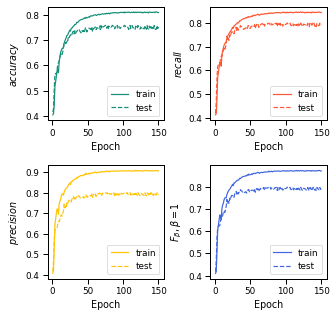

In [6]:
fig, axs = plt.subplots(2,2, figsize=(5, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for metric in colors.keys():
    x = log_df['epoch'].values
    y = log_df['train_{}'.format(metric)].values
    position = [int(p) for p in positions[metric].split(',')]
    ax = axs[position[0], position[1]]
    ax.plot(x,y, label='train', color=colors[metric])
    
    y = log_df['test_{}'.format(metric)].values
    ax.plot(x,y, label='test', linestyle='--', color=colors[metric])
    ax.set_ylabel('{}'.format(names[metric]))
    ax.set_xlabel('Epoch')
    ax.legend()
plt.savefig('figures/{}/training.jpg'.format(version), bbox_inches = 'tight')
plt.show();

# Side-by-Side Comparison

In [16]:
version = 'sp'
df_all = pd.read_csv('logging/combined_bootstrap_analysis_batchsize256_{}.txt'.format(version))
df_o2n = pd.read_csv('logging/o2n_bootstrap_analysis_batchsize256_{}.txt'.format(version))
df_o2o = pd.read_csv('logging/o2o_bootstrap_analysis_batchsize256_{}.txt'.format(version))
df_o2z = pd.read_csv('logging/o2z_bootstrap_analysis_batchsize256_{}.txt'.format(version))
dfs = {
    'all': df_all,
    'o2n': df_o2n,
    'o2o': df_o2o,
    'o2z': df_o2z,
}
for df in dfs.values():
    df['fbeta'] = ''
    for idx, row in df.iterrows():
        _, recall, precision, _ = row
        row['fbeta'] = fbeta_score(precision, recall)
        df.loc[idx] = row

In [17]:
df_o2z.head()

,accuracy,recall,precision,fbeta
0,0.971429,0.971429,0.971429,0.971429
1,0.985507,0.985507,0.985507,0.985507
2,1.000000,1.000000,1.000000,1
3,0.982143,0.982143,0.982143,0.982143
4,0.971429,0.971429,0.971429,0.971429


In [18]:
metrics = {
    'mean': {},
    'recall': {},
    'precision': {},
    'fbeta': {}
}
for key, df in dfs.items():
    accuracies = list(df['accuracy'].values)
    metrics['mean'][key] = mean_confidence_interval(accuracies)
    
    recalls = list(df['recall'].values)
    metrics['recall'][key] = mean_confidence_interval(recalls)
    
    precisions = list(df['precision'].values)
    metrics['precision'][key] = mean_confidence_interval(precisions)
    
    fbetas = list(df['fbeta'].values)
    metrics['fbeta'][key] = mean_confidence_interval(fbetas)

In [19]:
metrics

{'mean': {'all': (0.6081715029761904, 0.016393329101407714),
  'o2n': (0.23442041122068297, 0.02099557209168035),
  'o2o': (0.6163462974226646, 0.024108805590521358),
  'o2z': (0.9862341600846436, 0.007706694419852395)},
 'recall': {'all': (0.6257543855883699, 0.015008515731840788),
  'o2n': (0.29853808381261787, 0.01490569298290299),
  'o2o': (0.6163462974226646, 0.024108805590521358),
  'o2z': (0.9862341600846436, 0.007706694419852395)},
 'precision': {'all': (0.743359375, 0.018349886209326278),
  'o2n': (0.7357036611807932, 0.047771891904966605),
  'o2o': (0.6163462974226646, 0.024108805590521358),
  'o2z': (0.9862341600846436, 0.007706694419852395)},
 'fbeta': {'all': (0.6794668238977466, 0.016080676271376167),
  'o2n': (0.42451029358885767, 0.02216477570956323),
  'o2o': (0.6163462974226646, 0.024108805590521358),
  'o2z': (0.9862341600846436, 0.007706694419852395)}}

In [20]:
df_o2z.head()

,accuracy,recall,precision,fbeta
0,0.971429,0.971429,0.971429,0.971429
1,0.985507,0.985507,0.985507,0.985507
2,1.000000,1.000000,1.000000,1
3,0.982143,0.982143,0.982143,0.982143
4,0.971429,0.971429,0.971429,0.971429


In [23]:
for key, df in dfs.items():
    fig, axs = plt.subplots(2,2, figsize=(5, 5))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    for metric in colors.keys():
        data = list(df[metric].values)
        position = [int(p) for p in positions[metric].split(',')]
        ax = axs[position[0], position[1]]
        sns.distplot(data, color=colors[metric],bins=np.linspace(0.75, 1, 100), ax=ax);
        ax.set_xlabel(names[metric], fontsize=12)
        ax.set_xlim((0, 1))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(10)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(10)
    plt.savefig('figures/{}/{}_dist.jpg'.format(version, key), bbox_inches = 'tight')
    plt.close()